In [1]:
import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from utils.global_paths import project_data_path
from utils.constants import obs_names, obs_names_plot

from matplotlib.colors import LinearSegmentedColormap

cm_data = np.loadtxt("../src/utils/colormaps/lapaz.txt")[::-1]
lapaz_cmap = LinearSegmentedColormap.from_list("cmap", cm_data)

cm_data = np.loadtxt("../src/utils/colormaps/lajolla.txt")[::-1]
lajolla_cmap = LinearSegmentedColormap.from_list("cmap", cm_data)

In [3]:
# Set fonts
from matplotlib import font_manager
font_dirs = ["/storage/home/dcl5300/fonts"]

font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)
    
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.size"] = 12
plt.rcParams["font.sans-serif"] = "Arial"
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["axes.linewidth"] = 1.5

# Soil moisture product intercomparison 

In [4]:
# Read all
subset_name = "eCONUS"

ds_obs_all = []

for obs_name in obs_names:
    ds = xr.open_dataset(
        f"{project_data_path}/WBM/calibration/{subset_name}/{obs_name}/{obs_name}_validation.nc"
    )
    ds = ds.assign_coords(obs_name=obs_name)
    ds_obs_all.append(ds)

ds_obs_all = xr.concat(ds_obs_all, dim="obs_name").drop_vars("depth")[
    "soilMoist"
]

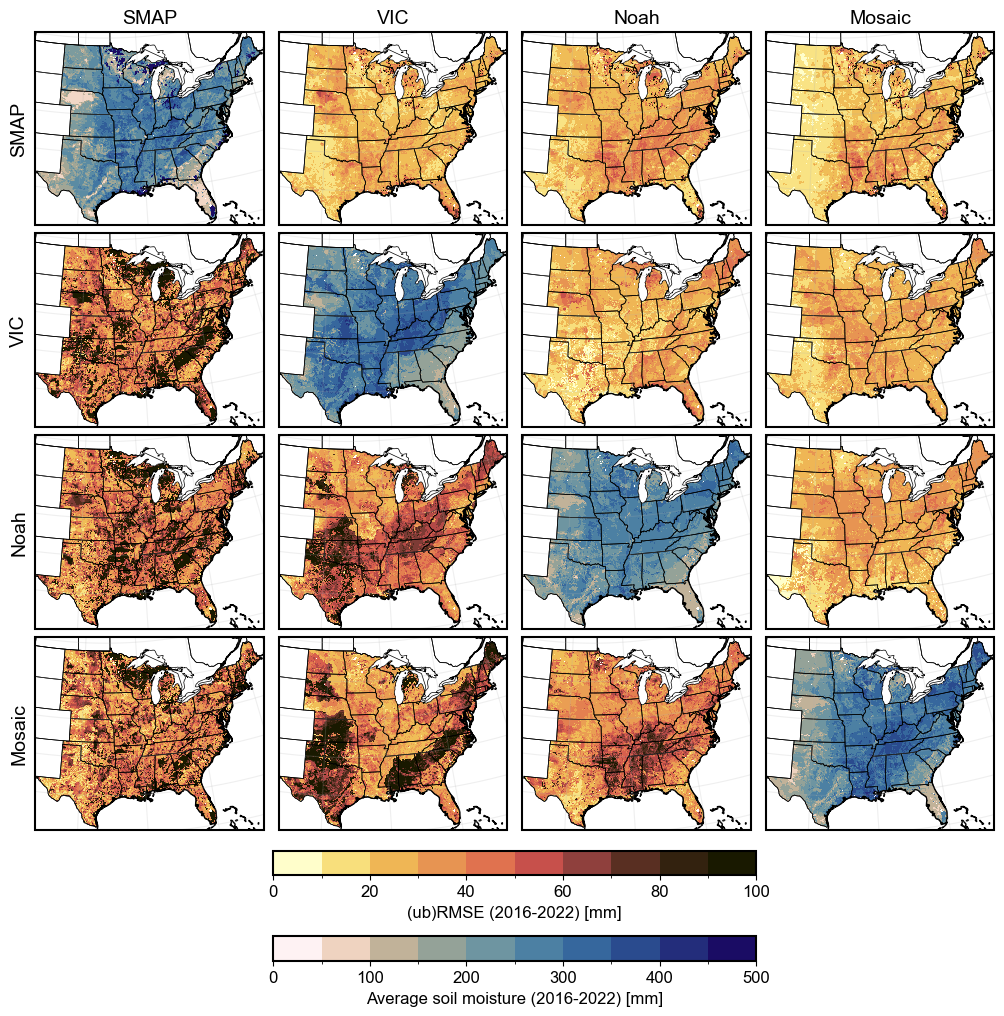

In [7]:
# Pairwise comparison
cmap_mean = lapaz_cmap
vmax_mean = 500.0

cmap_diff = lajolla_cmap
vmax_diff = 100.0

fig, axs = plt.subplots(
    4,
    4,
    figsize=(10, 10),
    sharex=True,
    sharey=True,
    layout="constrained",
    subplot_kw=dict(projection=ccrs.LambertConformal()),
)

# Loop through combinations
for ido1, obs_name1 in enumerate(obs_names):
    for ido2, obs_name2 in enumerate(obs_names):
        ax = axs[ido1, ido2]
        # Diagonal: mean
        if ido1 == ido2:
            pmean = (
                ds_obs_all.isel(obs_name=ido1)
                .mean(dim="time")
                .plot(
                    ax=ax,
                    vmin=0,
                    vmax=vmax_mean,
                    levels=11,
                    cmap=cmap_mean,
                    add_colorbar=False,
                    transform=ccrs.PlateCarree(),
                )
            )
            ax.set_title("")
        # RMSE
        elif ido1 > ido2:
            ds_rmse = np.sqrt(
                (
                    (
                        ds_obs_all.isel(obs_name=ido1)
                        - ds_obs_all.isel(obs_name=ido2)
                    )
                    ** 2
                ).mean(dim="time")
            )
            ds_rmse.plot(
                ax=ax,
                vmin=0,
                vmax=vmax_diff,
                levels=11,
                cmap=cmap_diff,
                add_colorbar=False,
                transform=ccrs.PlateCarree(),
            )
        # ubRMSE
        elif ido2 > ido1:
            ds1_cenered = ds_obs_all.isel(obs_name=ido1) - ds_obs_all.isel(
                obs_name=ido1
            ).mean(dim="time")
            ds2_cenered = ds_obs_all.isel(obs_name=ido2) - ds_obs_all.isel(
                obs_name=ido2
            ).mean(dim="time")
            ds_rmse = np.sqrt(
                ((ds1_cenered - ds2_cenered) ** 2).mean(dim="time")
            )
            pdiff = ds_rmse.plot(
                ax=ax,
                vmin=0,
                vmax=vmax_diff,
                levels=11,
                cmap=cmap_diff,
                add_colorbar=False,
                transform=ccrs.PlateCarree(),
            )

        # Tidy
        gl = ax.gridlines(
            draw_labels=True, x_inline=False, rotate_labels=False, alpha=0.2
        )
        gl.top_labels = False
        gl.left_labels = False
        gl.bottom_labels = False
        gl.right_labels = False

        if ido2 == 0:
            ax.text(
                -0.07,
                0.5,
                obs_names_plot[obs_name1],
                horizontalalignment="center",
                fontsize=14,
                rotation=90,
                verticalalignment="center",
                transform=ax.transAxes,
            )
        if ido1 == 0:
            ax.set_title(obs_names_plot[obs_name2], fontsize=14)

        # No lat-lon labels
        # if ido2 == 3:
        #     gl.right_labels = True
        # if ido1 == 3:
        #     gl.bottom_labels = True


# Tidy
for ax in axs.flatten():
    ax.coastlines()
    ax.add_feature(cfeature.STATES, edgecolor="black", linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, edgecolor="black", linewidth=0.5)
    ax.set_extent([-106, -73.5, 25, 49], ccrs.Geodetic())

# Colorbars
fig.colorbar(
    pmean,
    orientation="horizontal",
    label="Average soil moisture (2016-2022) [mm]",
    ax=axs,
    pad=0.02,
    shrink=0.5,
)

fig.colorbar(
    pdiff,
    orientation="horizontal",
    label="(ub)RMSE (2016-2022) [mm]",
    ax=axs,
    pad=0.02,
    shrink=0.5,
)

plt.savefig("../figs/main/fig2_pairwise_comparison.png", dpi=600)